In [155]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

# Functions for Preprocessing & Scaling Data

In [156]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Run the code again to define and test the Min-Max scaling functions
# Define the function for Min-Max scaling
def min_max_scaling(data):
    """
    Normalize the data using Min-Max scaling.
    Args:
    - data (DataFrame): The data to normalize

    Returns:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column
    """
    scaling_params = {}
    normalized_data = data.copy()

    for column in data.columns:
        min_val = data[column].min()
        max_val = data[column].max()
        scaling_params[column] = {'min': min_val, 'max': max_val}
        normalized_data[column] = (data[column] - min_val) / (max_val - min_val)

    return normalized_data, scaling_params

# Define the function for inverse Min-Max scaling
def inverse_min_max_scaling(normalized_data, scaling_params):
    """
    Reverse the Min-Max scaling to get the original data.
    Args:
    - normalized_data (DataFrame): The normalized data
    - scaling_params (dict): The minimum and maximum values used for scaling for each column

    Returns:
    - original_data (DataFrame): The data in its original scale
    """
    original_data = normalized_data.copy()

    for idx, column in enumerate(normalized_data.columns):
        # Convert integer column names to string to match with scaling_params keys
        key = str(column) if isinstance(column, int) else column
        keys = list(scaling_params.keys())
        min_val = scaling_params[keys[int(key)]]['min']
        max_val = scaling_params[keys[int(key)]]['max']
        original_data[column] = normalized_data[column] * (max_val - min_val) + min_val

    return original_data

# Outlier Handling Functions

**Replace outliers for each weekday and each time slot with median for that slot and weekday**

In [157]:
def outlier_handler(data):
    # Convert the 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'])

    # Extract day of the week and time from the 'date' column
    data['day_of_week'] = data['date'].dt.day_name()
    data['time'] = data['date'].dt.time

    # Define a function to replace outliers with median for each group
    def replace_outliers(group):
        # Iterate over each column in the group
        for col in group.columns:
            if col not in ['date', 'day_of_week', 'time']:
                # Compute the IQR
                Q1 = group[col].quantile(0.25)
                Q3 = group[col].quantile(0.75)
                IQR = Q3 - Q1

                # Define bounds for outliers
                lower_bound = Q1 - 0.75 * IQR
                upper_bound = Q3 + 0.75 * IQR

                # Replace outliers with median of the group
                median_val = group[col].median()
                group[col] = group[col].apply(lambda x: median_val if x < lower_bound or x > upper_bound else x)

        return group

    # Group by 'day_of_week' and 'time' and apply the function to replace outliers
    data = data.groupby(['day_of_week', 'time']).apply(replace_outliers)
    data = data.drop(columns=['day_of_week','time'])

    return data

# Function for Handling Zero Points

In [158]:
def zero_handler(data, range):
    data['date'] = pd.to_datetime(data['date'])
    data['weekday'] = data['date'].dt.dayofweek
    data['time'] = data['date'].dt.time

    # Loop over each segment column
    for col in data.columns[1:-2]:
        # Group by weekday and time slot
        grouped = data.groupby(['weekday', 'time'])

        # Define a function to apply to each group
        def replace_zeros(group):
            nonzero_mean = group[group != 0].mean()
            if pd.notnull(nonzero_mean):
                return group.replace(0, nonzero_mean)
            else:
                return group

        # Apply the function to each group in the specific segment column
        data[col] = grouped[col].transform(replace_zeros)

    data = data.drop(columns=['weekday','time'])

    return handle_zeros_with_rolling_mean(data, range)

In [159]:
def handle_zeros_with_rolling_mean(data, range):
    for col in data.columns[1:]:
        mv_avg = data[col].rolling(range).mean()
        for i, val in enumerate(data[col]):
            if val == 0:
                data.loc[i,col] = mv_avg[i]
    data = data.tail(-(range))
    return data

# Function for Converting data into sequential data

**Get a matrix of 8 hour window as X and its next step values as Y**

In [160]:
def formatting_features_targets(data_values, window_size, step_i,dates):
    # Preprocessing and reshaping data
    num_sequences = len(data_values) - window_size
    X = np.array([data_values[i:i+window_size] for i in range(num_sequences)])
    y = np.array([data_values[i+window_size+step_i-1] for i in range(num_sequences)])
    d = np.array([dates[i+window_size+step_i-1] for i in range(num_sequences)])
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

    return X, y,d

# Transformer Model

In [161]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatioTemporalModel(nn.Module):
    def __init__(self, input_size, output_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dropout_rate=0.1):
        super(SpatioTemporalModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)
        # self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        # self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size after convolutional layers
        self.flattened_size = (input_size[1] // 4) * (input_size[2] // 4) * 32  # Dividing by 4 due to two pooling layers
        # Bottleneck layer to adjust the dimensionality to d_model
        self.bottleneck = nn.Linear(self.flattened_size, d_model)

        # Transformer layers
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_rate
        )

        # Linear layer for prediction
        self.fc1 = nn.Linear(d_model, d_model//2)
        self.fc2 = nn.Linear(d_model//2, d_model//4)
        self.fc3 = nn.Linear(d_model//4, output_size)

    def forward(self, x):
        # Convolutional layers
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # Flattening
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)

        # Transformer layers
        x = x.unsqueeze(0)
        x = self.transformer(x, x)
        x = x.squeeze(0)

        # Linear layer for prediction
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x

# Placing Data into Torch Tensors Functions

In [162]:
def get_torch_tensor(df, device):
    return torch.tensor(df, dtype=torch.float32).to(device)

def get_train_val_test_loaders(X_scaled, y_scaled, val_fraction, test_fraction, device, batch_size, dates):
    test_splitter = round(len(X_scaled)*(1-test_fraction))
    X_train_val_scaled , X_test_scaled = X_scaled[:test_splitter] , X_scaled[test_splitter:]
    y_train_val_scaled , y_test_scaled = y_scaled[:test_splitter] , y_scaled[test_splitter:]
    dates_train_val_scaled , dates_test_scaled = dates[:test_splitter] , dates[test_splitter:]

    train_val_splitter = round(len(X_train_val_scaled)*(1-val_fraction))
    X_train_scaled , X_val_scaled = X_train_val_scaled[:train_val_splitter] , X_train_val_scaled[train_val_splitter:]
    y_train_scaled , y_val_scaled = y_train_val_scaled[:train_val_splitter] , y_train_val_scaled[train_val_splitter:]
    dates_train_scaled , dates_val_scaled = dates_train_val_scaled[:train_val_splitter] , dates_train_val_scaled[train_val_splitter:]

    X_train_tensor = get_torch_tensor(X_train_scaled, device)
    y_train_tensor = get_torch_tensor(y_train_scaled, device)
    X_val_tensor = get_torch_tensor(X_val_scaled, device)
    y_val_tensor = get_torch_tensor(y_val_scaled, device)
    X_test_tensor = get_torch_tensor(X_test_scaled, device)
    y_test_tensor = get_torch_tensor(y_test_scaled, device)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, dates_test_scaled


In [163]:
def training(model, train_loader, val_loader):
    # Training loop with tqdm progress bar
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    num_epochs = 15
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        for X_batch, y_batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            with torch.no_grad():
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)
                total_val_loss+=loss
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] => Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Error Metrics Functions

## For Overall

In [164]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluateModel(model, val_loader, device, scaling_params=None):
    """
    Evaluate the model and return MSE, RMSE, and MAE.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - mse (float): Mean Squared Error
    - rmse (float): Root Mean Squared Error
    - mae (float): Mean Absolute Error
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    mse = mean_squared_error(all_true_values, all_predictions)
    rmse = mean_squared_error(all_true_values, all_predictions, squared=False)
    mae = mean_absolute_error(all_true_values, all_predictions)

    return mse, rmse, mae,all_predictions,all_true_values

# Dummy code to simulate usage (We don't have the actual model and data here, so this is just for illustration)
# evaluate_model(model, val_loader, device, scaling_params)


## Errors by Segment

In [165]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Let's update the evaluate_model_per_segment function to compute MSE, RMSE, and MAE for each segment
def evaluate_model_per_segment(model, val_loader, device, scaling_params=None):
    """
    Evaluate the model for each segment and return metrics.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column

    Returns:
    - segment_metrics (dict): Metrics (MSE, RMSE, MAE) for each segment
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    num_segments = all_predictions.shape[1]
    segment_metrics = {}

    from sklearn.metrics import mean_absolute_error
    overall_mae = mean_absolute_error(all_predictions, all_true_values)
    print(f"Overall Error Metrics ==> MAE : {overall_mae}")

    # Calculate MSE, RMSE, and MAE for each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        mse = np.mean((segment_predictions - segment_true_values)**2)
        rmse = np.sqrt(mse)
        # mae = np.mean(np.abs(segment_predictions - segment_true_values))
        mae = mean_absolute_error(segment_predictions, segment_true_values)

        segment_metrics[f"Segment {segment_idx+1}"] = {"MSE": mse, "RMSE": rmse, "MAE": mae}

    return segment_metrics

def evaluate_segments(model, test_loader, device, scaling_params=None):
    segment_metrics = evaluate_model_per_segment(model, test_loader, device, scaling_params)

    # Display metrics for each segment
    for segment, metrics in segment_metrics.items():
        print(f"{segment} => MSE: {metrics['MSE']:.4f}, RMSE: {metrics['RMSE']:.4f}, MAE: {metrics['MAE']:.4f}")


## Visualizing Performance of Model against each segment

In [166]:
# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Update the visualize_sorted_predictions function to reverse the normalization
def visualize_sorted_predictions(model, val_loader, device, scaling_params=None):
    """
    Visualize the sorted predictions and true values in their original scale.

    Args:
    - model: The trained model
    - val_loader: DataLoader for the validation set
    - device: The device type ('cpu' or 'cuda')
    - scaling_params (dict, optional): The minimum and maximum values used for scaling for each column
    """
    model.eval()  # Set model to evaluation mode

    all_predictions = []
    all_true_values = []

    # Fetch predictions and true values
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            predictions = model(X_batch)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_values.extend(y_batch.cpu().numpy())

    # Convert to arrays for indexing
    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)

    num_segments = all_predictions.shape[1]
    # print(inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params))

    # If scaling_params are provided, reverse the normalization
    if scaling_params:
        all_predictions = inverse_min_max_scaling(pd.DataFrame(all_predictions), scaling_params).values
        all_true_values = inverse_min_max_scaling(pd.DataFrame(all_true_values), scaling_params).values

    # Plotting each segment
    for segment_idx in range(num_segments):
        segment_predictions = all_predictions[:, segment_idx]
        segment_true_values = all_true_values[:, segment_idx]

        # Sorting the actual values and adjusting predictions accordingly
        # sorted_indices = np.argsort(segment_true_values)
        # sorted_true_values = segment_true_values[sorted_indices]
        # sorted_predictions = segment_predictions[sorted_indices]

        # sorted_indices = np.argsort(segment_true_values)
        sorted_true_values = segment_true_values
        sorted_predictions = segment_predictions

        plt.figure(figsize=(12, 6))
        plt.plot(sorted_true_values, label="Actual Values", color='blue')
        plt.plot(sorted_predictions, label="Predicted Values", color='red')
        plt.title(f"Segment {segment_idx+1}")
        plt.xlabel("Sequence Index")
        plt.ylabel("Value")
        plt.legend()
        plt.show()


# Obtainig GPU CUDA

In [167]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Loading the Data

In [168]:
# timestep used for data
minutes = 5

In [169]:
# Load the dataset
orig_df = pd.read_csv('/kaggle/input/busarrival/avg_run_5min_all_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/datasets/avg_run_{minutes}min_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Semester 5 DSE Project/Data/avg_run_{minutes}min_dir1.csv')

# orig_df = pd.read_csv(f'/content/drive/MyDrive/Project Datasets/avg_run_{minutes}min_dir1.csv')

orig_df = orig_df.drop(columns=['temp','precip','windspeed'])

In [170]:
# orig_df.rename(columns={'datetime': 'date'}, inplace=True)


In [171]:
orig_df.loc[len(orig_df)-1]

date    2022-11-01 18:55:00
1                       0.0
2                       0.0
3                       0.0
4                       0.0
5                       0.0
6                       0.0
7                       0.0
8                       0.0
9                       0.0
10                      0.0
11                      0.0
12                      0.0
13                      0.0
14                    101.0
15                    320.0
Name: 42431, dtype: object

# Applying the ML Process

In [172]:
zero_handle_range = int((15/minutes)*6)
data2 = orig_df
# data2 = outlier_handler(orig_df)
data2 = zero_handler(data2, zero_handle_range)
timeslots = data2['date'].values
data2 = data2.drop(columns=['date'])

data2, scaling_params2 = min_max_scaling(data2)
data_values2 = data2.values

window_size = int(8/(minutes/60))
step_i = 1
X2, y2, times = formatting_features_targets(data_values2, window_size, step_i,timeslots)

In [173]:
d_model = 512
batchSize = 64
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2

In [174]:
# Initialize the model
model2 = SpatioTemporalModel(input_size=X2.shape[1:], output_size=y2.shape[1], d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers)

In [175]:
train_loader2, val_loader2, test_loader2, dates_test = get_train_val_test_loaders(X2, y2, 0.02, 0.2, device, batchSize, times)

In [176]:
model2.to(device)
training(model2, train_loader2, val_loader2)

Epoch 1 Validation: 100%|██████████| 11/11 [00:00<00:00, 251.56it/s]


Epoch [1/15] => Train Loss: 0.0052, Val Loss: 0.0056


Epoch 2 Validation: 100%|██████████| 11/11 [00:00<00:00, 252.58it/s]


Epoch [2/15] => Train Loss: 0.0044, Val Loss: 0.0052


Epoch 3 Validation: 100%|██████████| 11/11 [00:00<00:00, 253.24it/s]


Epoch [3/15] => Train Loss: 0.0039, Val Loss: 0.0044


Epoch 4 Validation: 100%|██████████| 11/11 [00:00<00:00, 256.61it/s]


Epoch [4/15] => Train Loss: 0.0037, Val Loss: 0.0044


Epoch 5 Validation: 100%|██████████| 11/11 [00:00<00:00, 249.74it/s]


Epoch [5/15] => Train Loss: 0.0036, Val Loss: 0.0044


Epoch 6 Validation: 100%|██████████| 11/11 [00:00<00:00, 257.93it/s]


Epoch [6/15] => Train Loss: 0.0036, Val Loss: 0.0043


Epoch 7 Validation: 100%|██████████| 11/11 [00:00<00:00, 258.37it/s]


Epoch [7/15] => Train Loss: 0.0035, Val Loss: 0.0043


Epoch 8 Validation: 100%|██████████| 11/11 [00:00<00:00, 256.23it/s]


Epoch [8/15] => Train Loss: 0.0035, Val Loss: 0.0042


Epoch 9 Validation: 100%|██████████| 11/11 [00:00<00:00, 253.45it/s]


Epoch [9/15] => Train Loss: 0.0034, Val Loss: 0.0042


Epoch 10 Validation: 100%|██████████| 11/11 [00:00<00:00, 257.04it/s]


Epoch [10/15] => Train Loss: 0.0034, Val Loss: 0.0042


Epoch 11 Validation: 100%|██████████| 11/11 [00:00<00:00, 256.48it/s]


Epoch [11/15] => Train Loss: 0.0033, Val Loss: 0.0042


Epoch 12 Validation: 100%|██████████| 11/11 [00:00<00:00, 257.97it/s]


Epoch [12/15] => Train Loss: 0.0033, Val Loss: 0.0042


Epoch 13 Validation: 100%|██████████| 11/11 [00:00<00:00, 258.25it/s]


Epoch [13/15] => Train Loss: 0.0033, Val Loss: 0.0042


Epoch 14 Validation: 100%|██████████| 11/11 [00:00<00:00, 255.53it/s]


Epoch [14/15] => Train Loss: 0.0033, Val Loss: 0.0044


Epoch 15 Validation: 100%|██████████| 11/11 [00:00<00:00, 243.85it/s]

Epoch [15/15] => Train Loss: 0.0016, Val Loss: 0.0015


In [177]:
mse2, rmse2, mae2, pred, trueVal = evaluateModel(model2, test_loader2, device, scaling_params2)
print(f"MSE: {mse2:.4f}, RMSE: {rmse2:.4f}, MAE: {mae2:.4f}")
# v1 - MSE: 1747.1942, RMSE: 33.6750, MAE: 25.9307
# v3 - MSE: 1448.6693, RMSE: 31.2468, MAE: 23.5870
# v4 - MSE: 2346.4839, RMSE: 37.4656, MAE: 30.4317 batch size = 1

# 10 min - MSE: 404.0626, RMSE: 16.7137, MAE: 10.1751
# 5  min - MSE: 107.9190, RMSE: 8.8442, MAE: 2.0576
# 15 min - MSE: 478.6729, RMSE: 18.7366, MAE: 12.1529

# with zerohandler
#  5 min - MSE: 165.3000, RMSE: 11.0085, MAE: 5.8335

MSE: 1006.5772, RMSE: 28.7681, MAE: 18.1826


In [178]:
evaluate_segments(model2, test_loader2, device, scaling_params2)


Overall Error Metrics ==> MAE : 18.182552337646484
Segment 1 => MSE: 469.9951, RMSE: 21.6794, MAE: 14.1863
Segment 2 => MSE: 1517.7274, RMSE: 38.9580, MAE: 26.6962
Segment 3 => MSE: 1976.7147, RMSE: 44.4603, MAE: 31.0885
Segment 4 => MSE: 532.6413, RMSE: 23.0790, MAE: 17.0167
Segment 5 => MSE: 321.0650, RMSE: 17.9183, MAE: 11.9369
Segment 6 => MSE: 2899.3074, RMSE: 53.8452, MAE: 32.1105
Segment 7 => MSE: 227.7253, RMSE: 15.0906, MAE: 8.7294
Segment 8 => MSE: 136.2791, RMSE: 11.6739, MAE: 7.7625
Segment 9 => MSE: 57.7073, RMSE: 7.5965, MAE: 5.0313
Segment 10 => MSE: 1000.7538, RMSE: 31.6347, MAE: 19.6270
Segment 11 => MSE: 1899.8535, RMSE: 43.5873, MAE: 28.2965
Segment 12 => MSE: 633.3360, RMSE: 25.1662, MAE: 15.3713
Segment 13 => MSE: 459.5922, RMSE: 21.4381, MAE: 13.5584
Segment 14 => MSE: 889.6602, RMSE: 29.8272, MAE: 14.4655
Segment 15 => MSE: 2076.3008, RMSE: 45.5664, MAE: 26.8614


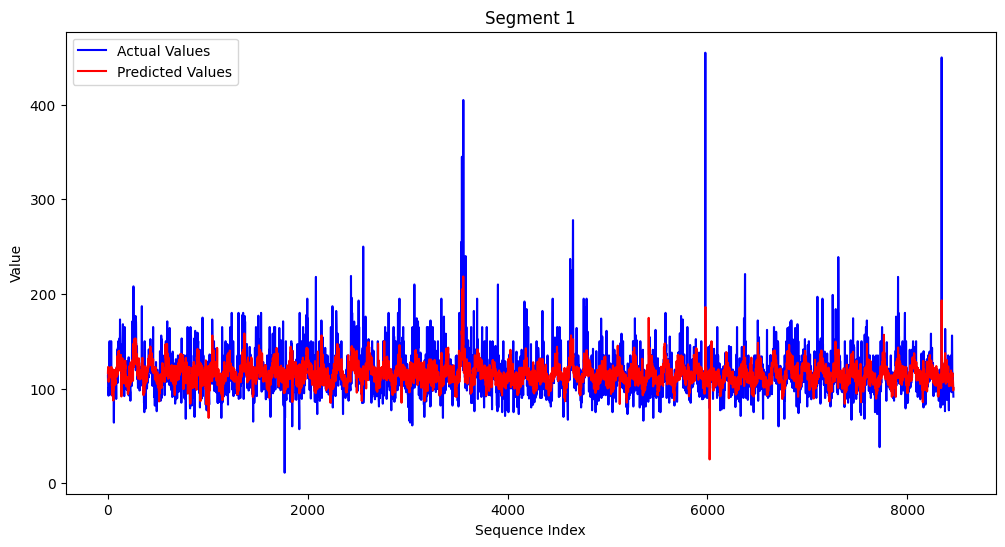

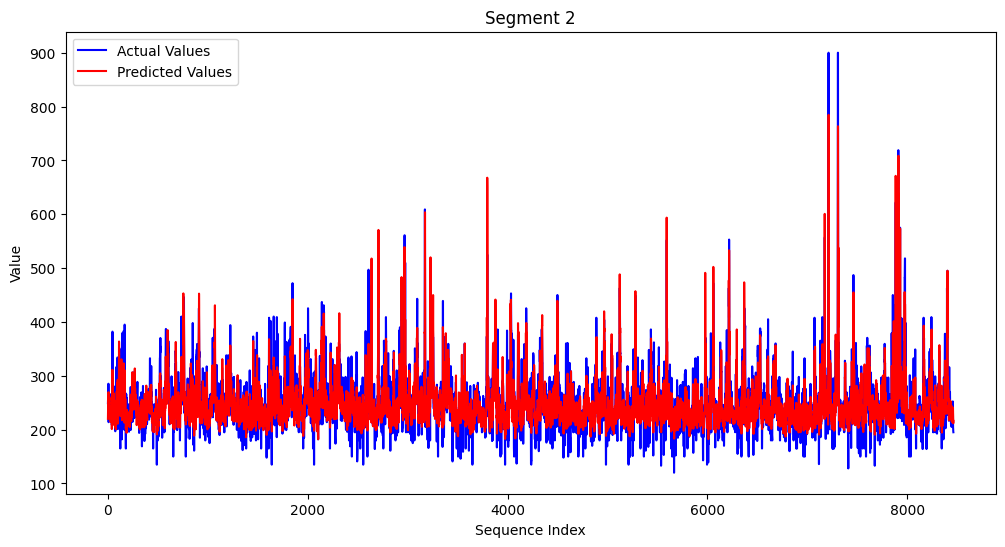

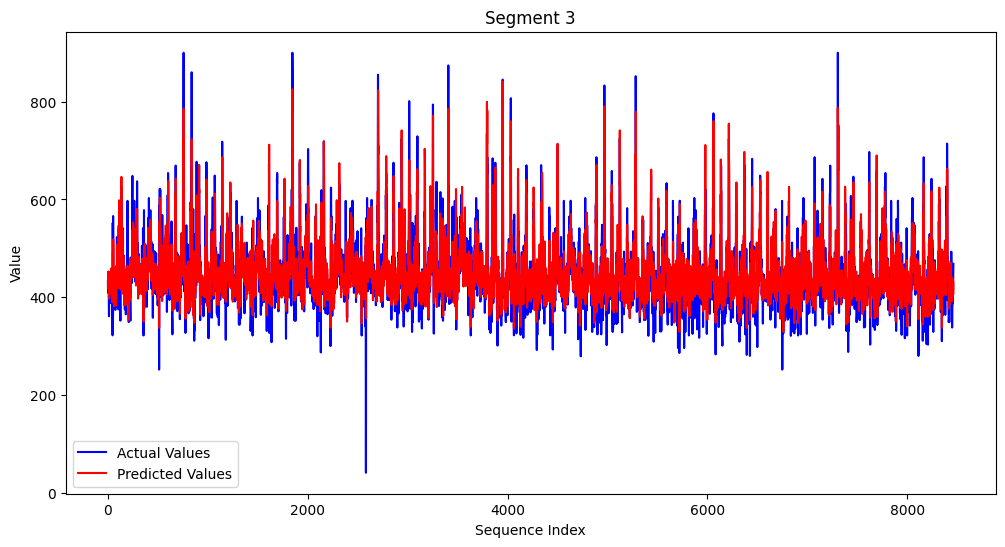

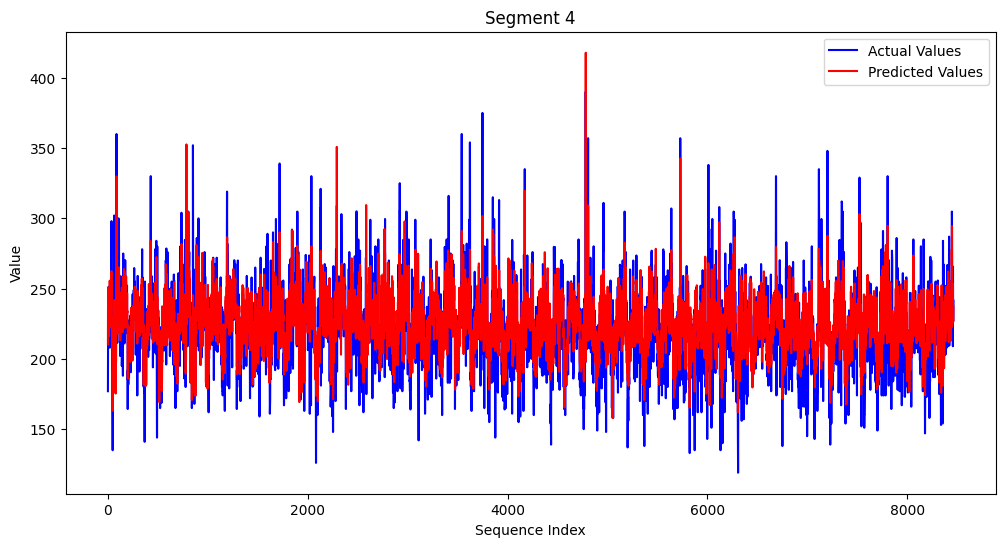

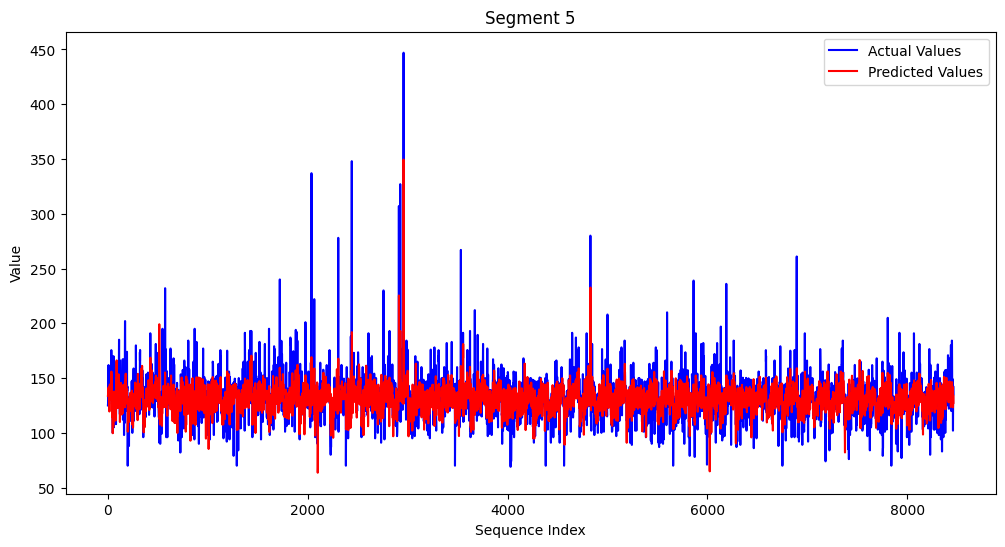

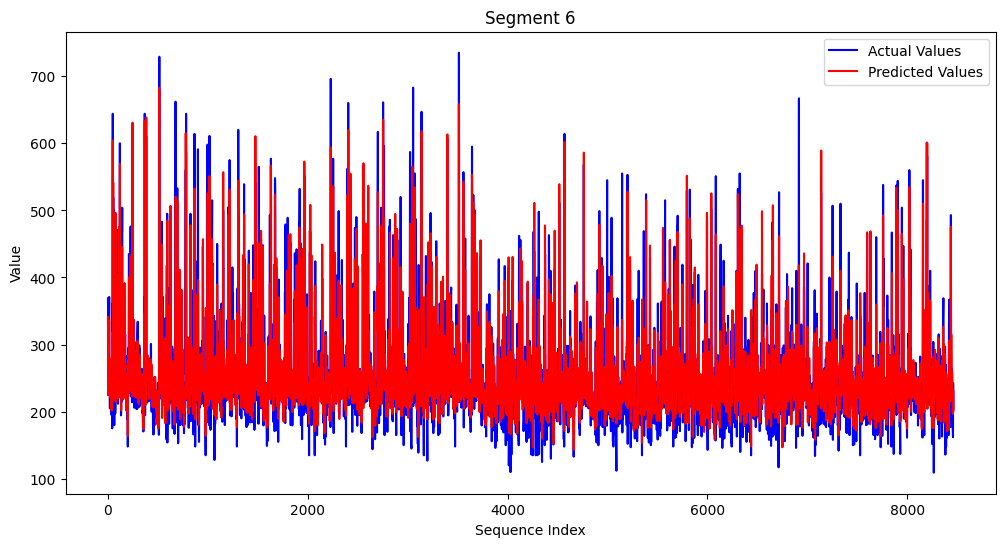

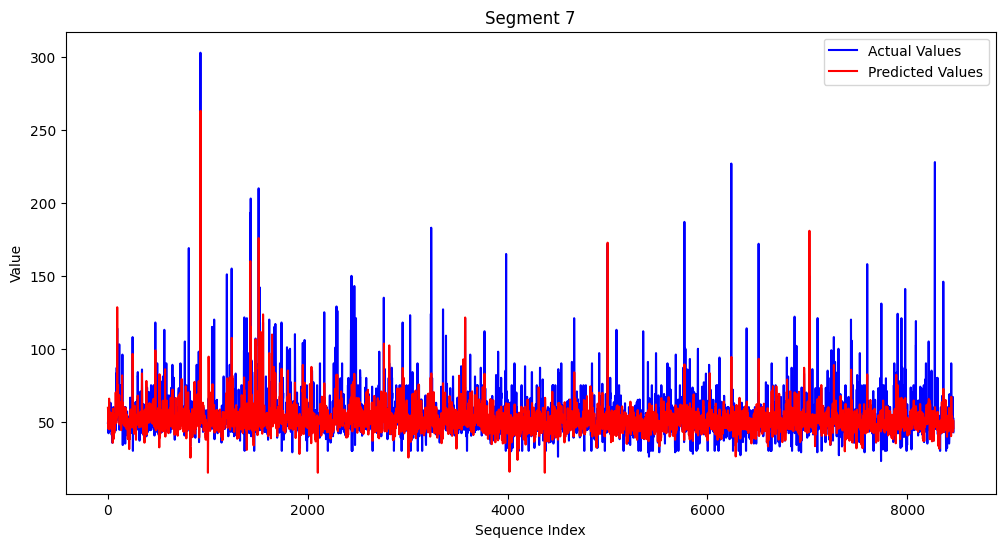

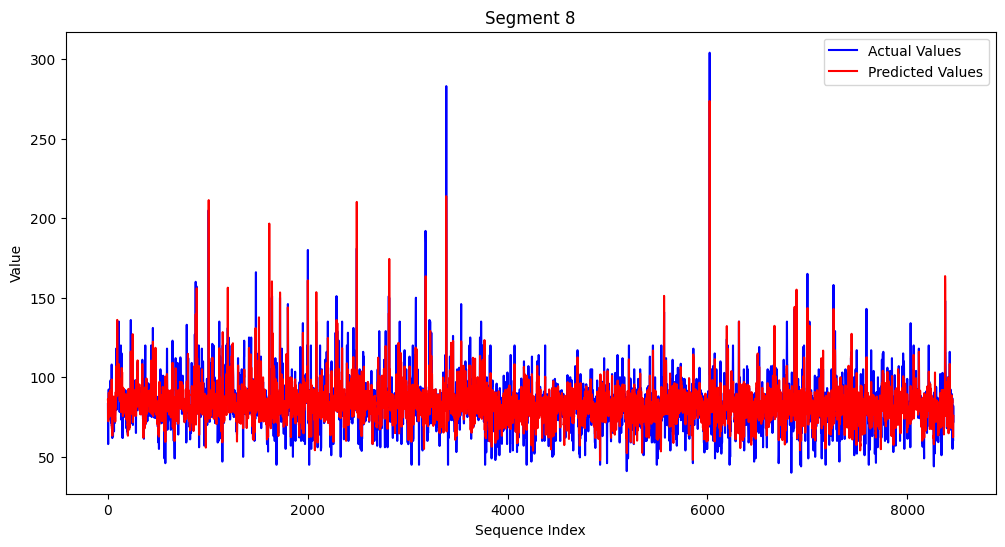

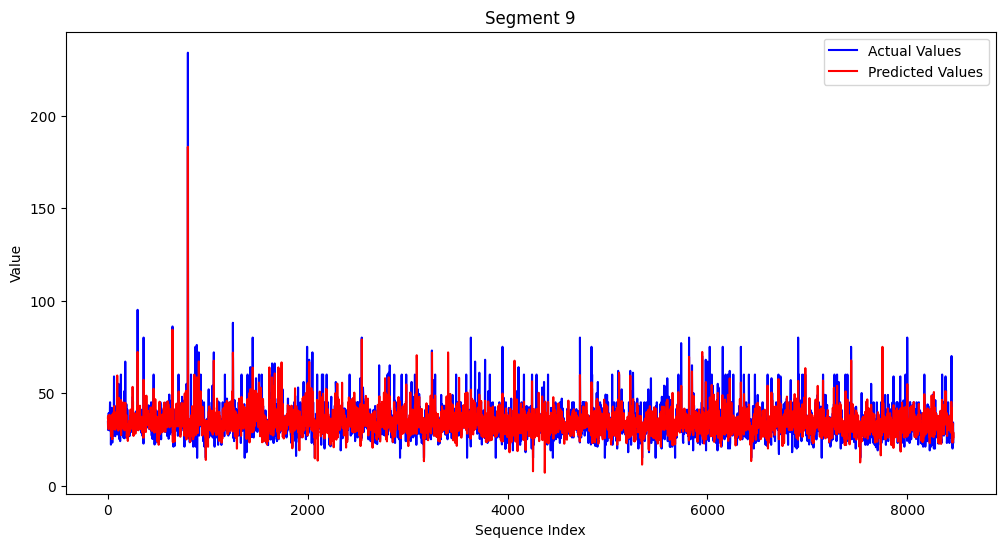

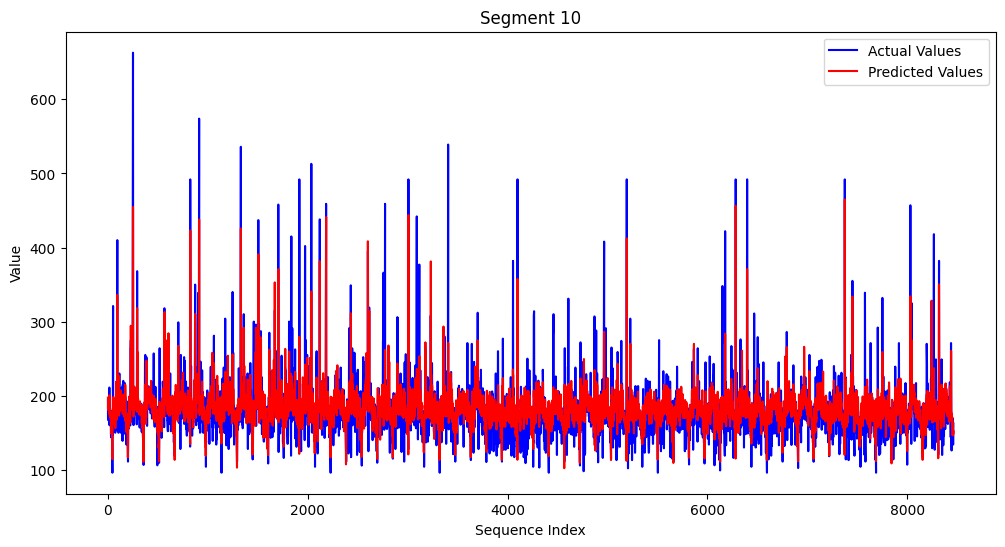

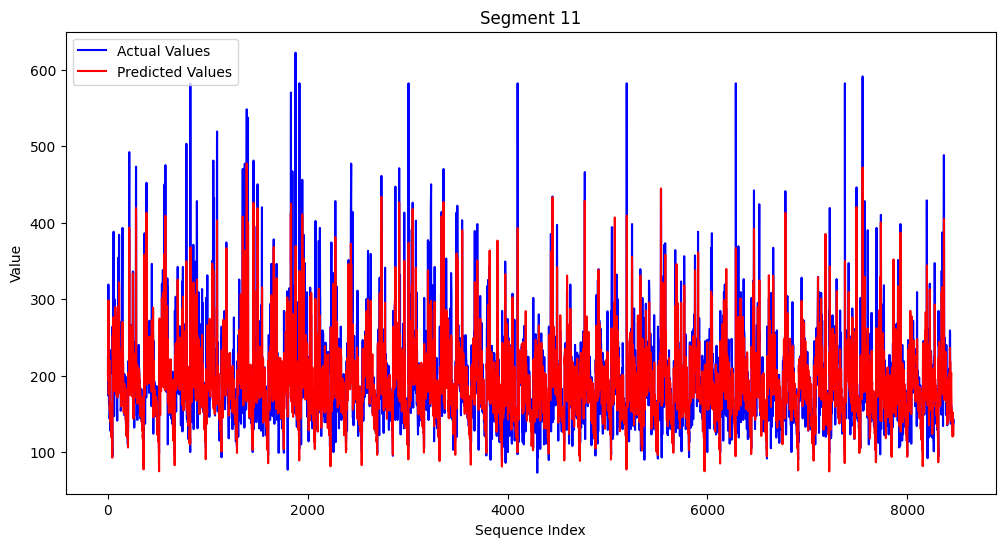

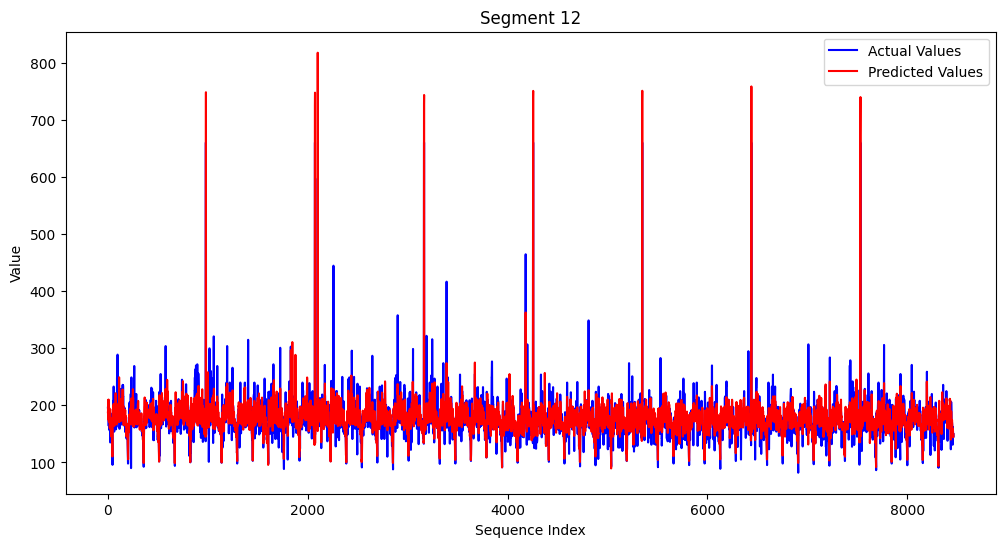

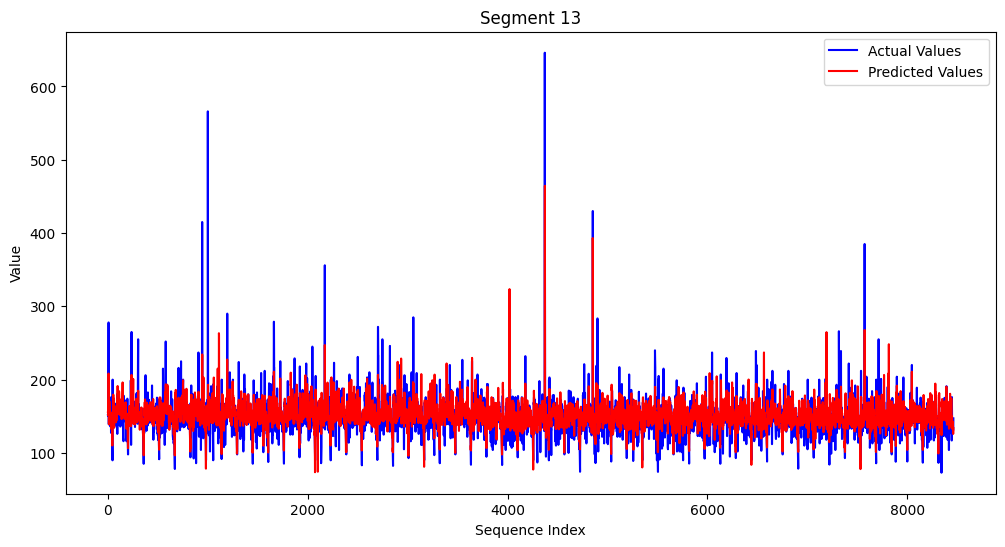

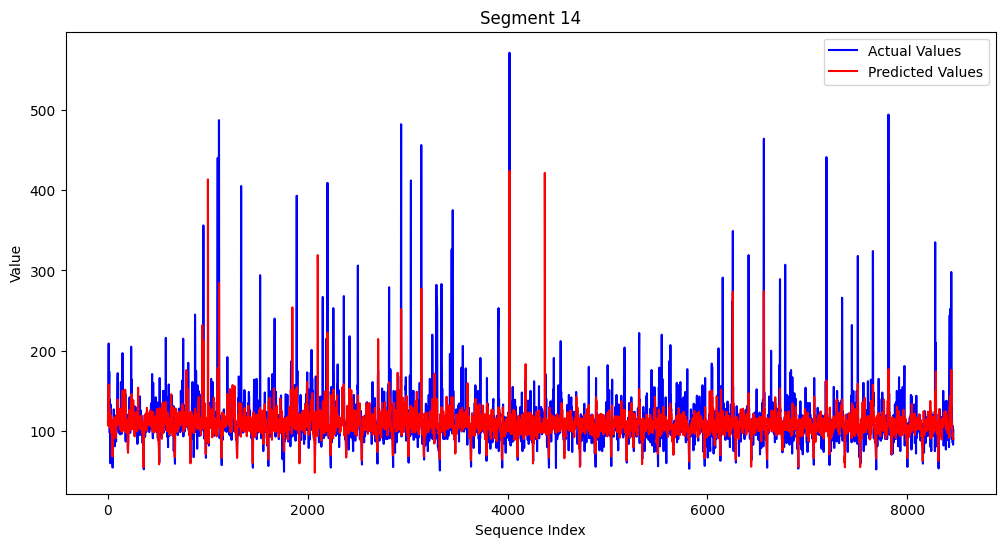

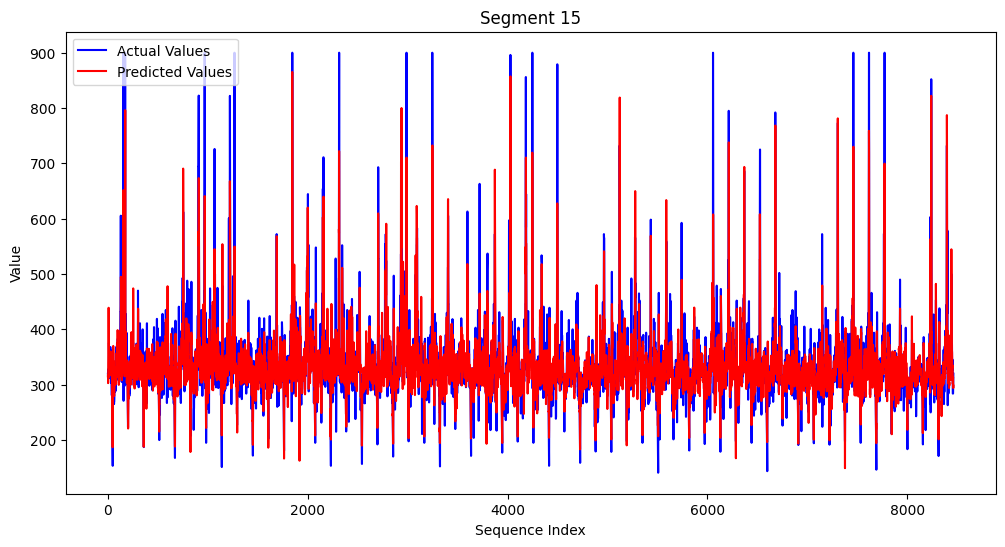

In [179]:
visualize_sorted_predictions(model2, test_loader2, device, scaling_params2)

In [180]:
r = 5

In [181]:
pred[r]

array([119.744675, 241.01369 , 452.17917 , 232.6249  , 138.35345 ,
       260.19208 ,  48.6803  ,  79.49458 ,  33.538948, 192.61728 ,
       298.21118 , 206.00041 , 164.36658 , 120.2637  , 317.3916  ],
      dtype=float32)

In [182]:
trueVal[r]

array([ 95.27778 , 285.26666 , 452.175   , 229.96667 , 159.55556 ,
       242.93333 ,  44.131577,  83.1     ,  32.176468, 166.70589 ,
       319.      , 191.      , 278.      , 126.5     , 316.09998 ],
      dtype=float32)

In [183]:
dates_test[r]

numpy.datetime64('2022-09-08T16:05:00.000000000')

In [184]:
# Creating the DataFrame
column_names = ['DateTime'] + [f'{idx+1}' for idx in range(len(pred[0]))]
data = []

for date, pred_values in zip(dates_test, pred):
    row = [date] + pred_values.tolist()
    data.append(row)

df_combined = pd.DataFrame(data, columns=column_names)

df_combined

,DateTime,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2022-09-08 15:40:00,116.505898,220.137115,419.440460,210.319153,133.886215,341.180115,59.541046,86.091995,36.655182,197.299561,200.576645,188.028931,156.046112,107.350586,315.176727
1,2022-09-08 15:45:00,121.314835,232.593719,440.817261,236.124664,134.922165,319.844055,58.265057,86.085739,37.608189,195.084534,211.839172,190.667023,157.177429,107.589233,317.722473
2,2022-09-08 15:50:00,122.794670,243.544846,437.263916,235.287491,139.622375,264.977417,54.589958,77.172386,32.736763,186.575897,195.569138,178.663605,152.900925,111.981911,302.845825
3,2022-09-08 15:55:00,121.508347,231.467514,429.959137,239.740341,135.267853,224.429672,45.318905,73.307167,33.443577,190.408081,193.807907,175.252350,151.482941,116.371658,311.884186
4,2022-09-08 16:00:00,121.860504,241.213791,434.482544,224.586426,137.809845,249.570114,48.483196,72.364227,33.004078,197.199158,285.538727,209.010345,171.626007,122.507050,316.990479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8459,2022-11-01 18:35:00,107.603004,240.836182,436.150330,229.549103,123.236549,196.728149,43.062099,66.751923,28.755116,160.451721,139.359650,154.038361,135.164642,92.026566,310.987854
8460,2022-11-01 18:40:00,104.609161,224.157318,419.497375,235.958771,126.057373,202.899323,44.087341,62.310966,24.633801,146.667206,128.339157,152.603775,134.386353,90.481979,314.047455
8461,2022-11-01 18:45:00,100.882851,221.163269,405.649841,237.674194,134.457932,232.335129,50.924149,70.764542,28.228079,150.925293,121.467590,143.954880,125.952629,90.758263,302.406738
8462,2022-11-01 18:50:00,98.001221,211.692429,425.935211,227.622482,133.217499,224.588486,50.476807,73.975441,28.765697,153.061996,128.256683,144.604309,130.062927,91.117188,293.976318


In [185]:
initial = pd.read_csv("/kaggle/input/busarrival/bus_running_times_feature_added_all.csv")

In [186]:
busses_new = initial[['trip_id','deviceid','direction','segment','date','start_time','end_time','run_time','run_time_in_seconds']]

In [187]:
busses_new.dropna(inplace=True)

/tmp/ipykernel_32/2107370339.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  busses_new.dropna(inplace=True)


In [188]:
segments = 15
time_step = 5
previous_steps = 15
pred_steps = 1
min = 1
lag = 0
start_time = '06:00:00'
end_time = '19:00:00'

In [189]:
mask = busses_new['segment'] <= segments

In [190]:
busses_new = busses_new[mask]

In [191]:
# Extract only the time from 'end_time' column
busses_new['start_time_only'] = pd.to_datetime(busses_new['start_time']).dt.time

# Combine 'date' and the extracted time to create 'start_datetime'
busses_new['start_datetime'] = pd.to_datetime(busses_new['date'] + ' ' + busses_new['start_time_only'].astype(str))

# Display the first few rows to verify
busses_new[['date', 'start_time_only', 'start_datetime']].head()


/tmp/ipykernel_32/1586254460.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  busses_new['start_time_only'] = pd.to_datetime(busses_new['start_time']).dt.time


,date,start_time_only,start_datetime
0,2021-10-01,06:39:49,2021-10-01 06:39:49
1,2021-10-01,06:42:12,2021-10-01 06:42:12
2,2021-10-01,06:45:42,2021-10-01 06:45:42
3,2021-10-01,06:54:04,2021-10-01 06:54:04
4,2021-10-01,06:57:19,2021-10-01 06:57:19


In [192]:
busses_new.head()

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime
0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,06:39:49,2021-10-01 06:39:49
1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,06:42:12,2021-10-01 06:42:12
2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,06:45:42,2021-10-01 06:45:42
3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,06:54:04,2021-10-01 06:54:04
4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,06:57:19,2021-10-01 06:57:19


In [193]:
# Loop through each row in busses_new
for index, row in busses_new.iterrows():
    # Get the end_datetime and segment values
    start_dt = row['start_datetime']
    segment = int(row['segment'])

    # Find the row in df_combined where start_datetime falls in the specified range
    mask = (df_combined['DateTime'] <= start_dt) & (df_combined['DateTime'] + pd.Timedelta(minutes=5) > start_dt)

    # If there's a matching row in df_combined
    if df_combined[mask].shape[0] > 0:
        # Get the predicted value using the segment number
        predicted_value = df_combined[mask].iloc[0][segment]

        # Assign the predicted value to the predicted_runTime column in busses_new
        busses_new.at[index, 'predicted_runTime'] = predicted_value
    else:
        busses_new.at[index, 'predicted_runTime'] = None

In [194]:
busses_new.dropna(inplace=True)

In [195]:
busses_new

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime,predicted_runTime
151045,22122.0,123.0,1.0,4.0,2022-09-08,15:44:27,15:47:24,0:02:57,177.0,15:44:27,2022-09-08 15:44:27,210.319153
151046,22122.0,123.0,1.0,5.0,2022-09-08,15:47:24,15:49:29,0:02:05,125.0,15:47:24,2022-09-08 15:47:24,134.922165
151047,22122.0,123.0,1.0,6.0,2022-09-08,15:49:44,15:55:53,0:06:09,369.0,15:49:44,2022-09-08 15:49:44,319.844055
151048,22122.0,123.0,1.0,7.0,2022-09-08,15:56:08,15:56:59,0:00:51,51.0,15:56:08,2022-09-08 15:56:08,45.318905
151049,22122.0,123.0,1.0,8.0,2022-09-08,15:57:14,15:58:12,0:00:58,58.0,15:57:14,2022-09-08 15:57:14,73.307167
...,...,...,...,...,...,...,...,...,...,...,...,...
173720,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,18:47:53,2022-11-01 18:47:53,121.467590
173721,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,18:50:15,2022-11-01 18:50:15,144.604309
173722,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,18:52:50,2022-11-01 18:52:50,130.062927
173723,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,18:55:14,2022-11-01 18:55:14,90.673050


In [196]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = busses_new['run_time_in_seconds']
predicted_values = busses_new['predicted_runTime']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 23.08634208934858
MSE: 1277.260710341121
RMSE: 35.73878439932059


In [197]:
busses_new.to_csv('finalPred.csv', index=False)

In [198]:
busses_new

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime,predicted_runTime
151045,22122.0,123.0,1.0,4.0,2022-09-08,15:44:27,15:47:24,0:02:57,177.0,15:44:27,2022-09-08 15:44:27,210.319153
151046,22122.0,123.0,1.0,5.0,2022-09-08,15:47:24,15:49:29,0:02:05,125.0,15:47:24,2022-09-08 15:47:24,134.922165
151047,22122.0,123.0,1.0,6.0,2022-09-08,15:49:44,15:55:53,0:06:09,369.0,15:49:44,2022-09-08 15:49:44,319.844055
151048,22122.0,123.0,1.0,7.0,2022-09-08,15:56:08,15:56:59,0:00:51,51.0,15:56:08,2022-09-08 15:56:08,45.318905
151049,22122.0,123.0,1.0,8.0,2022-09-08,15:57:14,15:58:12,0:00:58,58.0,15:57:14,2022-09-08 15:57:14,73.307167
...,...,...,...,...,...,...,...,...,...,...,...,...
173720,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,18:47:53,2022-11-01 18:47:53,121.467590
173721,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,18:50:15,2022-11-01 18:50:15,144.604309
173722,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,18:52:50,2022-11-01 18:52:50,130.062927
173723,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,18:55:14,2022-11-01 18:55:14,90.673050


/tmp/ipykernel_32/3272236291.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['hour'] = pd.to_datetime(data['start_time']).dt.hour


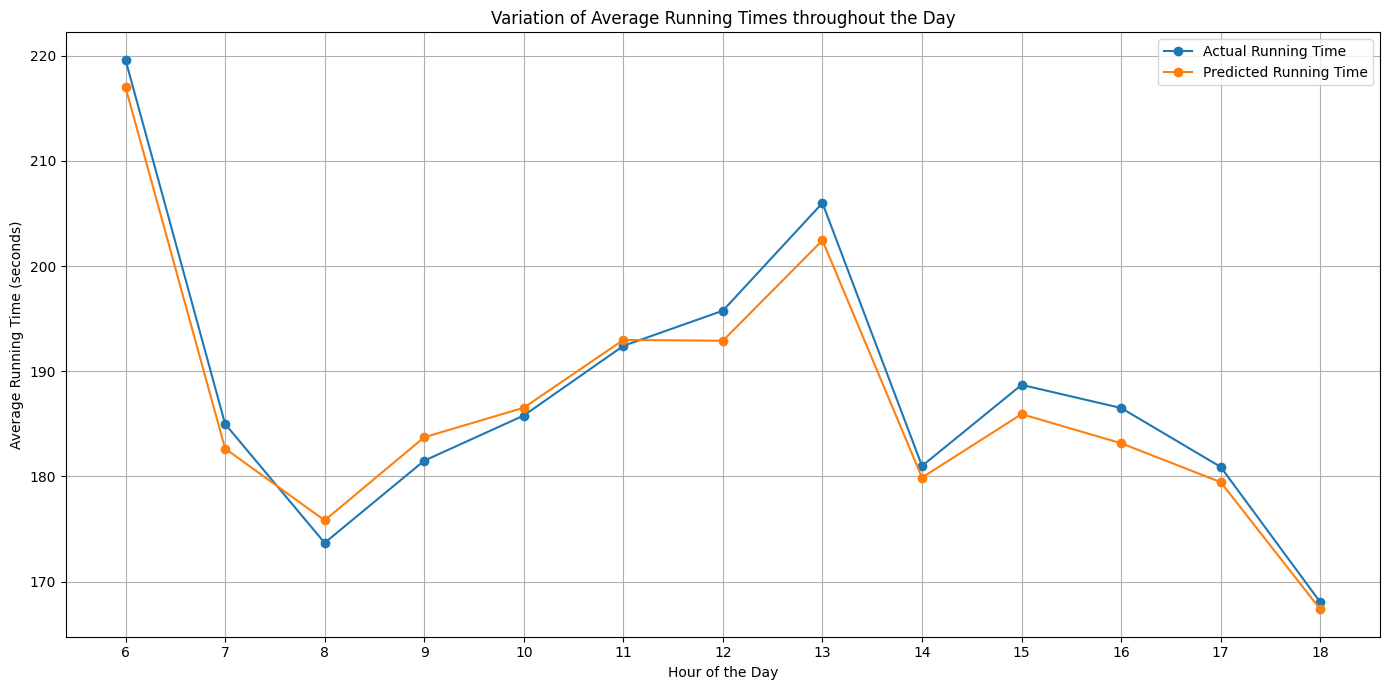

In [199]:
import matplotlib.pyplot as plt

data = busses_new
# Extract hour from the start_time column
data['hour'] = pd.to_datetime(data['start_time']).dt.hour

# Group by hour and calculate the average for both actual and predicted run times
grouped_data = data.groupby('hour').agg({
    'run_time_in_seconds': 'mean',
    'predicted_runTime': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(grouped_data['hour'], grouped_data['run_time_in_seconds'], label='Actual Running Time', marker='o')
plt.plot(grouped_data['hour'], grouped_data['predicted_runTime'], label='Predicted Running Time', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Running Time (seconds)')
plt.title('Variation of Average Running Times throughout the Day')
plt.legend()
plt.grid(True)
plt.xticks(grouped_data['hour'])
plt.tight_layout()
plt.show()


In [200]:
initial.columns

Index(['trip_id', 'deviceid', 'direction', 'segment', 'date', 'start_time',
       'end_time', 'run_time', 'run_time_in_seconds', 'length', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)',
       'rt(n-2)', 'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'conditions', 'dt(n-1)'],
      dtype='object')

In [201]:
ds = initial.copy()
ds.dropna(inplace=True)
mask = ds['segment'] <= segments
ds.head()

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,...,rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1)
0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,...,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,...,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0
2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,...,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,...,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0
4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,...,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0


In [202]:
X_data = ds[['trip_id', 'deviceid', 'segment', 'run_time_in_seconds', 'length', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)',
       'rt(n-2)', 'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'conditions', 'dt(n-1)']]
y_data = ds['run_time_in_seconds']

In [203]:
X_data.head()

,trip_id,deviceid,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,...,rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1)
0,1.0,262.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,...,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
1,1.0,262.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,...,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0
2,1.0,262.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,...,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0
3,1.0,262.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,...,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0
4,1.0,262.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,...,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0


In [204]:
y_data.head()

0     69.0
1    210.0
2    496.0
3    195.0
4     97.0
Name: run_time_in_seconds, dtype: float64

In [205]:
temp = busses_new.copy()

In [206]:
temp

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,start_time_only,start_datetime,predicted_runTime,hour
151045,22122.0,123.0,1.0,4.0,2022-09-08,15:44:27,15:47:24,0:02:57,177.0,15:44:27,2022-09-08 15:44:27,210.319153,15
151046,22122.0,123.0,1.0,5.0,2022-09-08,15:47:24,15:49:29,0:02:05,125.0,15:47:24,2022-09-08 15:47:24,134.922165,15
151047,22122.0,123.0,1.0,6.0,2022-09-08,15:49:44,15:55:53,0:06:09,369.0,15:49:44,2022-09-08 15:49:44,319.844055,15
151048,22122.0,123.0,1.0,7.0,2022-09-08,15:56:08,15:56:59,0:00:51,51.0,15:56:08,2022-09-08 15:56:08,45.318905,15
151049,22122.0,123.0,1.0,8.0,2022-09-08,15:57:14,15:58:12,0:00:58,58.0,15:57:14,2022-09-08 15:57:14,73.307167,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173720,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,18:47:53,2022-11-01 18:47:53,121.467590,18
173721,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,18:50:15,2022-11-01 18:50:15,144.604309,18
173722,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,18:52:50,2022-11-01 18:52:50,130.062927,18
173723,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,18:55:14,2022-11-01 18:55:14,90.673050,18


In [207]:
# Columns to consider for the merge
common_columns = ['trip_id', 'deviceid', 'direction', 'segment', 'date', 'start_time', 'end_time', 'run_time', 'run_time_in_seconds']

# Inner join 'ds' and 'temp' on the common columns
merged_df = ds.merge(temp, on=common_columns, how='inner')

merged_df

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,...,month,temp,precip,windspeed,conditions,dt(n-1),start_time_only,start_datetime,predicted_runTime,hour
0,22122.0,123.0,1.0,4.0,2022-09-08,15:44:27,15:47:24,0:02:57,177.0,1.55,...,9.0,24.9,0.1,14.8,"Rain, Overcast",6.0,15:44:27,2022-09-08 15:44:27,210.319153,15
1,22122.0,123.0,1.0,5.0,2022-09-08,15:47:24,15:49:29,0:02:05,125.0,0.84,...,9.0,24.9,0.1,14.8,"Rain, Overcast",0.0,15:47:24,2022-09-08 15:47:24,134.922165,15
2,22122.0,123.0,1.0,6.0,2022-09-08,15:49:44,15:55:53,0:06:09,369.0,1.31,...,9.0,24.9,0.1,14.8,"Rain, Overcast",15.0,15:49:44,2022-09-08 15:49:44,319.844055,15
3,22122.0,123.0,1.0,7.0,2022-09-08,15:56:08,15:56:59,0:00:51,51.0,0.37,...,9.0,24.9,0.1,14.8,"Rain, Overcast",15.0,15:56:08,2022-09-08 15:56:08,45.318905,15
4,22122.0,123.0,1.0,8.0,2022-09-08,15:57:14,15:58:12,0:00:58,58.0,0.62,...,9.0,24.9,0.1,14.8,"Rain, Overcast",15.0,15:57:14,2022-09-08 15:57:14,73.307167,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22675,25370.0,121.0,1.0,11.0,2022-11-01,18:47:53,18:50:08,0:02:15,135.0,1.10,...,11.0,20.5,0.0,8.3,Overcast,15.0,18:47:53,2022-11-01 18:47:53,121.467590,18
22676,25370.0,121.0,1.0,12.0,2022-11-01,18:50:15,18:52:39,0:02:24,144.0,1.31,...,11.0,20.5,0.0,8.3,Overcast,7.0,18:50:15,2022-11-01 18:50:15,144.604309,18
22677,25370.0,121.0,1.0,13.0,2022-11-01,18:52:50,18:55:01,0:02:11,131.0,1.15,...,11.0,20.5,0.0,8.3,Overcast,11.0,18:52:50,2022-11-01 18:52:50,130.062927,18
22678,25370.0,121.0,1.0,14.0,2022-11-01,18:55:14,18:56:55,0:01:41,101.0,0.89,...,11.0,20.5,0.0,8.3,Overcast,13.0,18:55:14,2022-11-01 18:55:14,90.673050,18


In [208]:
ds_not_in_merged = ds.merge(merged_df, on=common_columns, how='left', indicator=True).query('_merge == "left_only" ')

In [209]:
ds_not_in_merged

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length_x,...,temp_y,precip_y,windspeed_y,conditions_y,dt(n-1)_y,start_time_only,start_datetime,predicted_runTime,hour,_merge
0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200674,25367.0,1377.0,2.0,30.0,2022-11-01,18:17:36,18:24:21,0:06:45,405.0,2.5600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
200675,25367.0,1377.0,2.0,31.0,2022-11-01,18:24:21,18:25:36,0:01:15,75.0,0.4200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
200676,25367.0,1377.0,2.0,32.0,2022-11-01,18:25:49,18:28:10,0:02:21,141.0,1.3000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only
200677,25367.0,1377.0,2.0,33.0,2022-11-01,18:28:10,18:31:25,0:03:15,195.0,1.2200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,left_only


In [210]:
ds_not_in_merged.columns

Index(['trip_id', 'deviceid', 'direction', 'segment', 'date', 'start_time',
       'end_time', 'run_time', 'run_time_in_seconds', 'length_x',
       'day_of_week_x', 'time_of_day_x', 'Sunday/holiday_x', 'saturday_x',
       'weekday/end_x', 'week_no_x', 'rt(w-1)_x', 'rt(w-2)_x', 'rt(w-3)_x',
       'rt(t-1)_x', 'rt(t-2)_x', 'rt(n-1)_x', 'rt(n-2)_x', 'rt(n-3)_x',
       'hour_of_day_x', 'day_x', 'month_x', 'temp_x', 'precip_x',
       'windspeed_x', 'conditions_x', 'dt(n-1)_x', 'length_y', 'day_of_week_y',
       'time_of_day_y', 'Sunday/holiday_y', 'saturday_y', 'weekday/end_y',
       'week_no_y', 'rt(w-1)_y', 'rt(w-2)_y', 'rt(w-3)_y', 'rt(t-1)_y',
       'rt(t-2)_y', 'rt(n-1)_y', 'rt(n-2)_y', 'rt(n-3)_y', 'hour_of_day_y',
       'day_y', 'month_y', 'temp_y', 'precip_y', 'windspeed_y', 'conditions_y',
       'dt(n-1)_y', 'start_time_only', 'start_datetime', 'predicted_runTime',
       'hour', '_merge'],
      dtype='object')

In [211]:
X_train = ds_not_in_merged[['deviceid','segment', 'length_x',
       'day_of_week_x', 'time_of_day_x', 'Sunday/holiday_x', 'saturday_x',
       'weekday/end_x', 'week_no_x', 'rt(w-1)_x', 'rt(w-2)_x', 'rt(w-3)_x',
       'rt(t-1)_x', 'rt(t-2)_x', 'rt(n-1)_x', 'rt(n-2)_x', 'rt(n-3)_x',
       'hour_of_day_x', 'day_x', 'month_x', 'temp_x', 'precip_x',
       'windspeed_x', 'dt(n-1)_x']]

# Define a mapping of the old column names to the new column names
column_mapping = {
    'deviceid': 'deviceid',
    'segment': 'segment',
    'length_x': 'length',
    'day_of_week_x': 'day_of_week',
    'time_of_day_x': 'time_of_day',
    'Sunday/holiday_x': 'Sunday/holiday',
    'saturday_x': 'saturday',
    'weekday/end_x': 'weekday/end',
    'week_no_x': 'week_no',
    'rt(w-1)_x': 'rt(w-1)',
    'rt(w-2)_x': 'rt(w-2)',
    'rt(w-3)_x': 'rt(w-3)',
    'rt(t-1)_x': 'rt(t-1)',
    'rt(t-2)_x': 'rt(t-2)',
    'rt(n-1)_x': 'rt(n-1)',
    'rt(n-2)_x': 'rt(n-2)',
    'rt(n-3)_x': 'rt(n-3)',
    'hour_of_day_x': 'hour_of_day',
    'day_x': 'day',
    'month_x': 'month',
    'temp_x': 'temp',
    'precip_x': 'precip',
    'windspeed_x': 'windspeed',
    'dt(n-1)_x': 'dt(n-1)'
}

# Rename the columns in X_train
X_train.rename(columns=column_mapping, inplace=True)

y_train = ds_not_in_merged['run_time_in_seconds']

/tmp/ipykernel_32/3325625101.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.rename(columns=column_mapping, inplace=True)


In [212]:
X_train.head()

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1)
0,262.0,1.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,...,96.0,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,0.0
1,262.0,2.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,...,69.0,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,74.0
2,262.0,3.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,...,210.0,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,0.0
3,262.0,4.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,...,496.0,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,6.0
4,262.0,5.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,...,195.0,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,0.0


In [213]:
X_test = merged_df[['deviceid', 'segment', 'length', 'day_of_week',
       'time_of_day', 'Sunday/holiday', 'saturday', 'weekday/end', 'week_no',
       'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)',
       'rt(n-2)', 'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip',
       'windspeed', 'dt(n-1)']]

y_test = merged_df['run_time_in_seconds']
nn_pred = merged_df['predicted_runTime']

In [214]:
import xgboost as xgb

# Assuming X_train and y_train are your data
dtrain = xgb.DMatrix(X_train, label=y_train)

# Specify the parameters for the XGBoost regressor
params = {
    'objective': 'reg:squarederror',  # Specify regression as the task
    'tree_method': 'gpu_hist',  # Use GPU accelerated algorithm
}

# Train the model
model = xgb.train(params, dtrain)

# Now your model is trained and ready to make predictions!


In [215]:
# Assuming X_test and y_test are your test data
dtest = xgb.DMatrix(X_test)

# Use the trained model to make predictions
y_pred = model.predict(dtest)


In [216]:
X_test['run_time_in_seconds'] = y_test
X_test['xgbPred'] = y_pred
X_test['NNPred'] = nn_pred



/tmp/ipykernel_32/3931515983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['run_time_in_seconds'] = y_test
/tmp/ipykernel_32/3931515983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['xgbPred'] = y_pred
/tmp/ipykernel_32/3931515983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

In [217]:
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,hour_of_day,day,month,temp,precip,windspeed,dt(n-1),run_time_in_seconds,xgbPred,NNPred
0,123.0,4.0,1.55,3.0,15.50,0.0,0,1,34.0,221.0,...,15.0,8.0,9.0,24.9,0.1,14.8,6.0,177.0,211.744614,210.319153
1,123.0,5.0,0.84,3.0,15.75,0.0,0,1,34.0,136.0,...,15.0,8.0,9.0,24.9,0.1,14.8,0.0,125.0,139.062637,134.922165
2,123.0,6.0,1.31,3.0,15.75,0.0,0,1,34.0,322.0,...,15.0,8.0,9.0,24.9,0.1,14.8,15.0,369.0,298.394806,319.844055
3,123.0,7.0,0.37,3.0,15.75,0.0,0,1,34.0,60.0,...,15.0,8.0,9.0,24.9,0.1,14.8,15.0,51.0,59.352528,45.318905
4,123.0,8.0,0.62,3.0,15.75,0.0,0,1,34.0,90.0,...,15.0,8.0,9.0,24.9,0.1,14.8,15.0,58.0,89.537056,73.307167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22675,121.0,11.0,1.10,1.0,18.75,0.0,0,1,42.0,150.0,...,18.0,1.0,11.0,20.5,0.0,8.3,15.0,135.0,143.518906,121.467590
22676,121.0,12.0,1.31,1.0,18.75,0.0,0,1,42.0,165.0,...,18.0,1.0,11.0,20.5,0.0,8.3,7.0,144.0,143.716431,144.604309
22677,121.0,13.0,1.15,1.0,18.75,0.0,0,1,42.0,139.0,...,18.0,1.0,11.0,20.5,0.0,8.3,11.0,131.0,127.389290,130.062927
22678,121.0,14.0,0.89,1.0,18.75,0.0,0,1,42.0,102.0,...,18.0,1.0,11.0,20.5,0.0,8.3,13.0,101.0,93.391983,90.673050


In [218]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['run_time_in_seconds']
predicted_values = X_test['xgbPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE xgbPred: {mae}")
print(f"MSE xgbPred: {mse}")
print(f"RMSE xgbPred: {rmse}")


MAE xgbPred: 34.537098584015325
MSE xgbPred: 3241.8435723938323
RMSE xgbPred: 56.93718971282155


In [219]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['run_time_in_seconds']
predicted_values = X_test['NNPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE NNPred: {mae}")
print(f"MSE NNPred: {mse}")
print(f"RMSE NNPred: {rmse}")


MAE NNPred: 23.08634208934858
MSE NNPred: 1277.260710341121
RMSE NNPred: 35.73878439932059


In [220]:
X_test['avgPred'] = (X_test['xgbPred'] + X_test['NNPred'])/2

/tmp/ipykernel_32/748025921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['avgPred'] = (X_test['xgbPred'] + X_test['NNPred'])/2


In [221]:
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,day,month,temp,precip,windspeed,dt(n-1),run_time_in_seconds,xgbPred,NNPred,avgPred
0,123.0,4.0,1.55,3.0,15.50,0.0,0,1,34.0,221.0,...,8.0,9.0,24.9,0.1,14.8,6.0,177.0,211.744614,210.319153,211.031883
1,123.0,5.0,0.84,3.0,15.75,0.0,0,1,34.0,136.0,...,8.0,9.0,24.9,0.1,14.8,0.0,125.0,139.062637,134.922165,136.992401
2,123.0,6.0,1.31,3.0,15.75,0.0,0,1,34.0,322.0,...,8.0,9.0,24.9,0.1,14.8,15.0,369.0,298.394806,319.844055,309.119431
3,123.0,7.0,0.37,3.0,15.75,0.0,0,1,34.0,60.0,...,8.0,9.0,24.9,0.1,14.8,15.0,51.0,59.352528,45.318905,52.335716
4,123.0,8.0,0.62,3.0,15.75,0.0,0,1,34.0,90.0,...,8.0,9.0,24.9,0.1,14.8,15.0,58.0,89.537056,73.307167,81.422112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22675,121.0,11.0,1.10,1.0,18.75,0.0,0,1,42.0,150.0,...,1.0,11.0,20.5,0.0,8.3,15.0,135.0,143.518906,121.467590,132.493248
22676,121.0,12.0,1.31,1.0,18.75,0.0,0,1,42.0,165.0,...,1.0,11.0,20.5,0.0,8.3,7.0,144.0,143.716431,144.604309,144.160370
22677,121.0,13.0,1.15,1.0,18.75,0.0,0,1,42.0,139.0,...,1.0,11.0,20.5,0.0,8.3,11.0,131.0,127.389290,130.062927,128.726109
22678,121.0,14.0,0.89,1.0,18.75,0.0,0,1,42.0,102.0,...,1.0,11.0,20.5,0.0,8.3,13.0,101.0,93.391983,90.673050,92.032516


In [222]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Extract the actual and predicted values
actual_values = X_test['run_time_in_seconds']
predicted_values = X_test['avgPred']

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)

print(f"MAE avgPred: {mae}")
print(f"MSE avgPred: {mse}")
print(f"RMSE avgPred: {rmse}")


MAE avgPred: 27.300646683694612
MSE avgPred: 1878.3462784165697
RMSE avgPred: 43.339892459679334


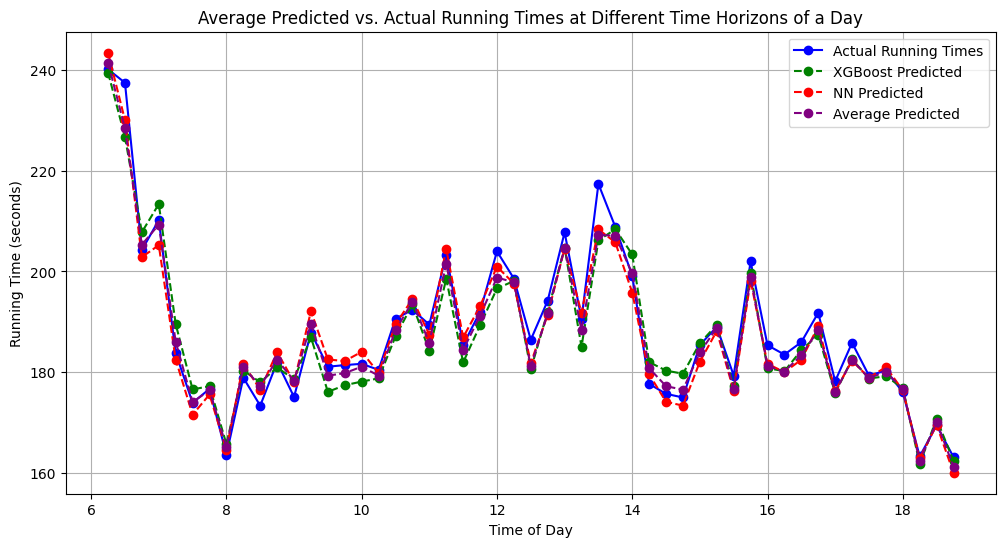

In [223]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named X_test with the provided dataset

# Group the data by time_of_day and calculate the mean for each group
grouped = X_test.groupby('time_of_day').mean()

# Extract the time_of_day and actual running times
time_of_day = grouped.index
actual_running_times = grouped['run_time_in_seconds']
xgb_pred = grouped['xgbPred']
nn_pred = grouped['NNPred']
avg_pred = grouped['avgPred']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, actual_running_times, label='Actual Running Times', marker='o', linestyle='-', color='blue')
plt.plot(time_of_day, xgb_pred, label='XGBoost Predicted', marker='o', linestyle='--', color='green')
plt.plot(time_of_day, nn_pred, label='NN Predicted', marker='o', linestyle='--', color='red')
plt.plot(time_of_day, avg_pred, label='Average Predicted', marker='o', linestyle='--', color='purple')

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Running Time (seconds)')
plt.title('Average Predicted vs. Actual Running Times at Different Time Horizons of a Day')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [224]:
X_test.columns

Index(['deviceid', 'segment', 'length', 'day_of_week', 'time_of_day',
       'Sunday/holiday', 'saturday', 'weekday/end', 'week_no', 'rt(w-1)',
       'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)', 'rt(n-2)',
       'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip', 'windspeed',
       'dt(n-1)', 'run_time_in_seconds', 'xgbPred', 'NNPred', 'avgPred'],
      dtype='object')

In [225]:
ensemble_X = X_test[['deviceid', 'segment', 'length', 'day_of_week', 'time_of_day',
       'Sunday/holiday', 'saturday', 'weekday/end', 'week_no', 'rt(w-1)',
       'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)', 'rt(n-2)',
       'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip', 'windspeed',
       'dt(n-1)',  'xgbPred', 'NNPred', 'avgPred']]
ensemble_y = X_test['run_time_in_seconds']

In [226]:
# from sklearn.model_selection import train_test_split
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(ensemble_X, ensemble_y, test_size=0.3, random_state=42)

# # Initialize the XGBoost regressor
# xgb_regressor = XGBRegressor()

# # Train the regressor on the training data
# xgb_regressor.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = xgb_regressor.predict(X_test)

# # Calculate the Mean Absolute Error (MAE) on the test set
# mae = mean_absolute_error(y_test, y_pred)

# # Print the MAE
# print(f"Mean Absolute Error (MAE): {mae}")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ensemble_X, ensemble_y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor()

# Train the regressor on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

# Calculate the Mean Absolute Error (MAE) on the test set
mae = mean_absolute_error(y_test, y_pred)

# Print the MAE
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 21.524609910836762


In [227]:
X_test['ensemble'] = y_pred
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,day,month,temp,precip,windspeed,dt(n-1),xgbPred,NNPred,avgPred,ensemble
1087,274.0,4.0,1.55,0.0,13.75,0.0,0,1,35.0,226.0,...,12.0,9.0,28.1,0.000,15.1,15.0,227.889404,237.994751,232.942078,233.11
15256,250.0,7.0,0.37,5.0,16.25,0.0,1,0,39.0,61.0,...,15.0,10.0,24.9,0.000,8.3,15.0,62.848343,54.997593,58.922968,69.06
4679,513.0,3.0,2.11,1.0,18.00,0.0,0,1,36.0,410.0,...,20.0,9.0,24.3,0.000,10.8,15.0,423.586670,413.701385,418.644028,392.30
14368,117.0,12.0,1.31,4.0,7.00,0.0,0,1,39.0,198.0,...,14.0,10.0,19.4,0.000,6.5,15.0,195.675095,194.749969,195.212532,195.86
15241,1377.0,7.0,0.37,5.0,15.75,0.0,1,0,39.0,60.0,...,15.0,10.0,25.8,0.000,9.0,15.0,57.945827,51.631065,54.788446,56.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12974,116.0,2.0,1.28,1.0,8.00,0.0,0,1,39.0,232.0,...,11.0,10.0,25.3,0.000,0.0,60.0,222.625153,218.885971,220.755562,194.66
15838,274.0,14.0,0.89,0.0,11.25,0.0,0,1,40.0,129.0,...,17.0,10.0,26.2,0.439,1.8,15.0,98.942657,110.869522,104.906090,106.02
289,262.0,12.0,1.31,4.0,13.00,0.0,0,1,34.0,206.0,...,9.0,9.0,27.6,0.000,16.6,15.0,214.920929,205.714111,210.317520,224.72
1121,262.0,8.0,0.62,0.0,16.00,0.0,0,1,35.0,91.0,...,12.0,9.0,27.2,0.000,16.2,15.0,91.183701,74.780563,82.982132,67.60


In [228]:
X_test['run_time_in_seconds'] = y_test
X_test

,deviceid,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),...,month,temp,precip,windspeed,dt(n-1),xgbPred,NNPred,avgPred,ensemble,run_time_in_seconds
1087,274.0,4.0,1.55,0.0,13.75,0.0,0,1,35.0,226.0,...,9.0,28.1,0.000,15.1,15.0,227.889404,237.994751,232.942078,233.11,217.0
15256,250.0,7.0,0.37,5.0,16.25,0.0,1,0,39.0,61.0,...,10.0,24.9,0.000,8.3,15.0,62.848343,54.997593,58.922968,69.06,100.0
4679,513.0,3.0,2.11,1.0,18.00,0.0,0,1,36.0,410.0,...,9.0,24.3,0.000,10.8,15.0,423.586670,413.701385,418.644028,392.30,404.0
14368,117.0,12.0,1.31,4.0,7.00,0.0,0,1,39.0,198.0,...,10.0,19.4,0.000,6.5,15.0,195.675095,194.749969,195.212532,195.86,172.0
15241,1377.0,7.0,0.37,5.0,15.75,0.0,1,0,39.0,60.0,...,10.0,25.8,0.000,9.0,15.0,57.945827,51.631065,54.788446,56.39,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12974,116.0,2.0,1.28,1.0,8.00,0.0,0,1,39.0,232.0,...,10.0,25.3,0.000,0.0,60.0,222.625153,218.885971,220.755562,194.66,238.0
15838,274.0,14.0,0.89,0.0,11.25,0.0,0,1,40.0,129.0,...,10.0,26.2,0.439,1.8,15.0,98.942657,110.869522,104.906090,106.02,116.0
289,262.0,12.0,1.31,4.0,13.00,0.0,0,1,34.0,206.0,...,9.0,27.6,0.000,16.6,15.0,214.920929,205.714111,210.317520,224.72,206.0
1121,262.0,8.0,0.62,0.0,16.00,0.0,0,1,35.0,91.0,...,9.0,27.2,0.000,16.2,15.0,91.183701,74.780563,82.982132,67.60,67.0


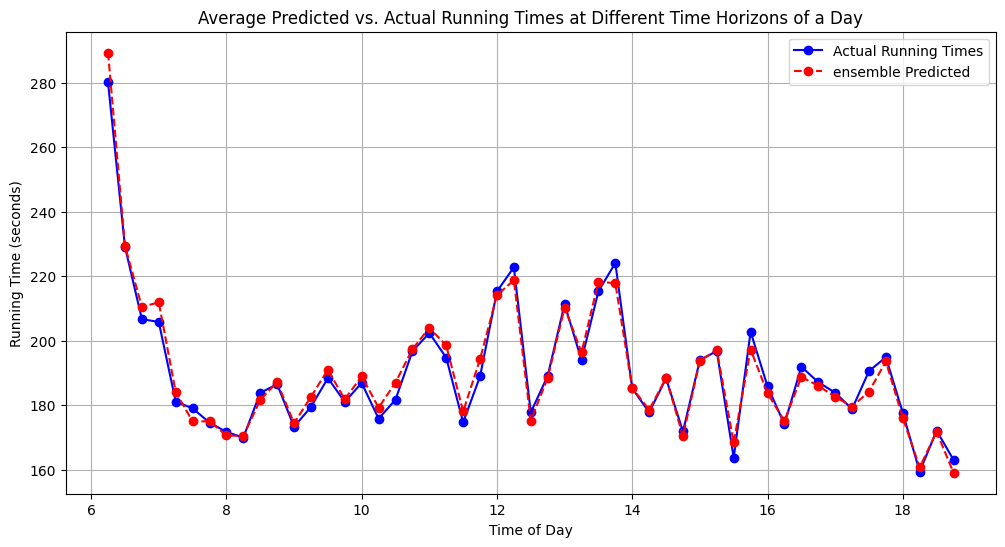

In [229]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named X_test with the provided dataset

# Group the data by time_of_day and calculate the mean for each group
grouped = X_test.groupby('time_of_day').mean()

# Extract the time_of_day and actual running times
time_of_day = grouped.index
actual_running_times = grouped['run_time_in_seconds']
xgb_pred = grouped['xgbPred']
nn_pred = grouped['NNPred']
avg_pred = grouped['ensemble']

# Create a line plot
plt.figure(figsize=(12, 6))
plt.plot(time_of_day, actual_running_times, label='Actual Running Times', marker='o', linestyle='-', color='blue')
# plt.plot(time_of_day, xgb_pred, label='XGBoost Predicted', marker='o', linestyle='--', color='green')
# plt.plot(time_of_day, nn_pred, label='NN Predicted', marker='o', linestyle='--', color='red')
plt.plot(time_of_day, avg_pred, label='ensemble Predicted', marker='o', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Time of Day')
plt.ylabel('Running Time (seconds)')
plt.title('Average Predicted vs. Actual Running Times at Different Time Horizons of a Day')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()
